In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import community as community_louvain

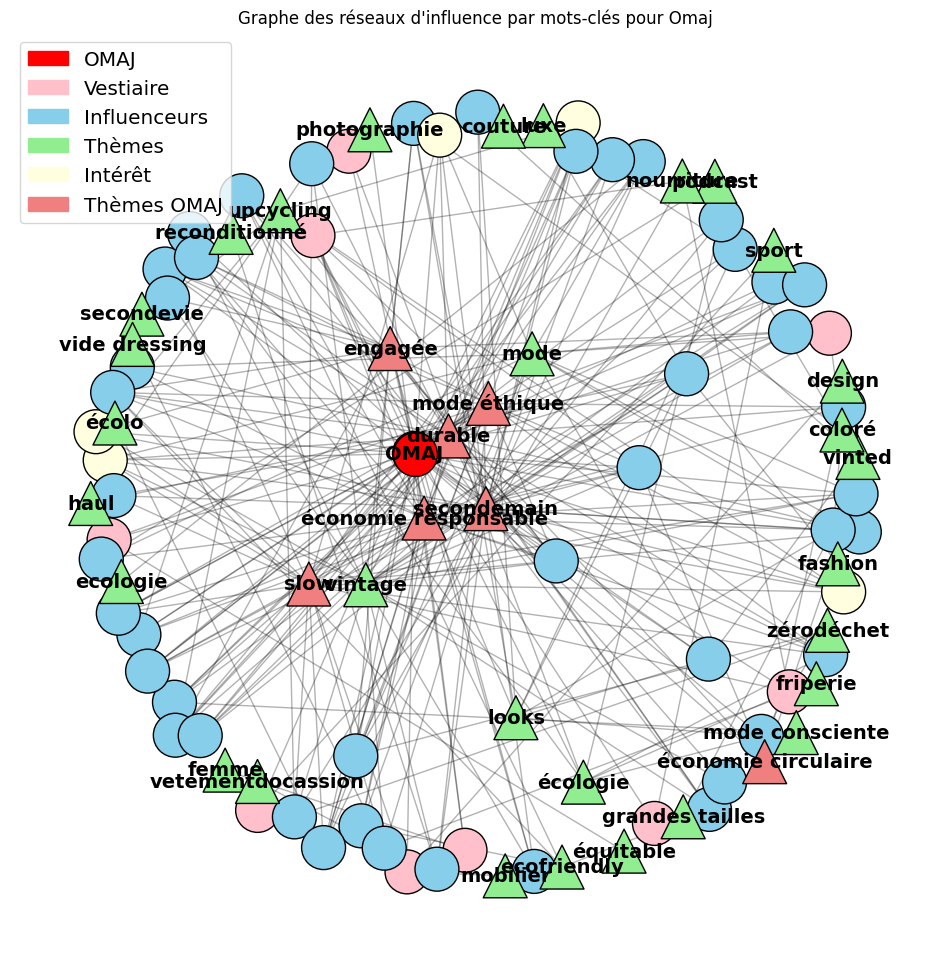

In [4]:
# data
df = pd.read_csv('../data/data.csv',sep=';')

# On split la colonne type de contenu pour créer des variables dummy
keywords = set()
for content in df["TYPE DE CONTENU"]:
    cleaned_keywords = [keyword.strip() for keyword in content.split(",")]
    keywords.update(cleaned_keywords)

for keyword in keywords:
    df[keyword] = df["TYPE DE CONTENU"].apply(lambda x: 1 if keyword in [k.strip() for k in x.split(",")] else 0)


# Liste des influenceurs "VESTIAIRE" d'OMAJ
highlight_influencers = [
    'claire_arnoux', 'iznowgood_', 'chloeandyou', 'mathildeclauzet', 
    'bonjourlasmala', 'melting.green', 'lapetillante_ju', 
    'asundaymorningperrine', 'carine.galli'
]
# Liste des mots clés d'OMAJ
highlight_keywords =[
    'économie responsable', 'secondemain','mode éthique', 'durable', 'engagée', 'économie circulaire', 'slow'
]

# Création du graphe
G = nx.Graph()

# Ajouter des noeuds pour les influenceurs
for influencer in df['INFLUENCEURS']:
    G.add_node(influencer, type='influencer')

# Ajouter des noeudds pour les mots-clés 
keywords = df.columns[4: ]  # Exclure les premières colonnes qui ne sont pas noeuds
for keyword in keywords:
    G.add_node(keyword, type='keyword')

# Ajouter des arêtes entre les influenceurs et les mots-clés
for index, row in df.iterrows():
    influencer = row['INFLUENCEURS']
    for keyword in keywords:
        if row[keyword] == 1:
            G.add_edge(influencer, keyword)
        
    # Ajouter les arêtes basées sur la relation de suivi : "suit omaj" et "est suivi par omaj"
    if row['SUIT OMAJ'] == 1 and row['SUIVI PAR OMAJ'] == 0:
        G.add_edge(influencer, "OMAJ")
    elif row['SUIT OMAJ'] == 1 and row['SUIVI PAR OMAJ'] == 1:
        G.add_edge(influencer, "OMAJ")
        G.add_edge("OMAJ", influencer)
    elif row['SUIT OMAJ'] == 0 and row['SUIVI PAR OMAJ'] == 1:
        G.add_edge("OMAJ", influencer)

# Séparer les noeuds des influenceurs et des mots-clés
influencers = [n for n, attr in G.nodes(data=True) if attr['type'] == 'influencer']
keywords = [n for n, attr in G.nodes(data=True) if attr['type'] == 'keyword']

# Définir les couleurs des noeuds
node_colors = []
for node in G.nodes():
    if node == "OMAJ":
        node_colors.append("red")
    elif node in highlight_influencers:
        node_colors.append('pink')
    elif node in highlight_keywords:
        node_colors.append('lightcoral')
    elif node in influencers:
        suit_omaj = df[df['INFLUENCEURS'] == node]['SUIT OMAJ'].values[0]
        suivi_par_omaj = df[df['INFLUENCEURS'] == node]['SUIVI PAR OMAJ'].values[0]
        if suit_omaj == 1 and suivi_par_omaj == 0:
            node_colors.append("lightyellow")
        else:
            node_colors.append("skyblue")
    else:
        node_colors.append("lightgreen")

plt.figure(figsize=(12, 12))

# Positionner les noeuds
pos = nx.spring_layout(G, k=3, iterations=102, seed=123)  # Ajuster les paramètres pour améliorer l'espacement

# Dessiner les noeuds et les arêtes
# Influenceurs en cercles
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=[node_colors[i] for i, n in enumerate(G.nodes()) if n in influencers], edgecolors='black',
                       nodelist=influencers)

# Mots-clés en triangles
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=[node_colors[i] for i, n in enumerate(G.nodes()) if n in keywords], edgecolors='black',
                       nodelist=keywords, node_shape='^')

# Dessiner les noeuds en évidence pour "OMAJ"
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='red', edgecolors='black',
                       nodelist=['OMAJ'])

# Dessiner les arêtes
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.3)

# Dessiner les étiquettes uniquement pour les noeuds en vert (mots-clés) et en rouge (OMAJ)
labels = {n: n for n in G.nodes() if n == "OMAJ" or n in keywords}
nx.draw_networkx_labels(G, pos, labels, font_size=14, font_weight='bold')

# Ajouter une légende
red_patch = mpatches.Patch(color='red', label='OMAJ')
pink_patch = mpatches.Patch(color='pink', label='Vestiaire')
blue_patch = mpatches.Patch(color='skyblue', label='Influenceurs')
green_patch = mpatches.Patch(color='lightgreen', label='Thèmes')
yellow_patch = mpatches.Patch(color='lightyellow', label='Intérêt')
lightcoral_patch = mpatches.Patch(color='lightcoral', label = 'Thèmes OMAJ')
plt.legend(handles=[red_patch, pink_patch, blue_patch, green_patch, yellow_patch, lightcoral_patch], loc='upper left', fontsize='x-large')

plt.title("Graphe des réseaux d'influence par mots-clés pour Omaj")
plt.axis('off') 
plt.show()

In [63]:

degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

centrality_df = pd.DataFrame({
    'influencer': df['INFLUENCEURS'],
    'degree_centrality': [degree_centrality[n] for n in df['INFLUENCEURS']],
    'betweenness_centrality': [betweenness_centrality[n] for n in df['INFLUENCEURS']],
    'closeness_centrality': [closeness_centrality[n] for n in df['INFLUENCEURS']],
    'eigenvector_centrality': [eigenvector_centrality[n] for n in df['INFLUENCEURS']]
})


centrality_df = centrality_df[centrality_df['influencer'] != 'OMAJ']

# Normalize the scores
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
centrality_df[['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']] = scaler.fit_transform(
    centrality_df[['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']])

# Calculate the total score
centrality_df['total_score'] = (centrality_df['degree_centrality'] +
                                centrality_df['betweenness_centrality'] +
                                centrality_df['closeness_centrality'] +
                                centrality_df['eigenvector_centrality'])

# Trier les influenceurs par le score total
top_influencers = centrality_df.sort_values(by='betweenness_centrality', ascending=False).head(10)

# Afficher les 10 meilleurs influenceurs
print("Top 10 des influenceurs recommandés :")
print(top_influencers[['influencer', 'total_score', 'degree_centrality','betweenness_centrality','closeness_centrality','eigenvector_centrality']])

Top 5 des influenceurs recommandés :
               influencer  total_score  degree_centrality  \
17         lesbonnesappes     2.697895                0.8   
11         juliettekitsch     3.200722                1.0   
6         lapetillante_ju     1.841906                0.4   
4          bonjourlasmala     1.344021                0.2   
27            maileuhnaye     2.297926                0.8   
24     aportugueseinparis     2.081717                0.8   
18     aportugueseinparis     2.081717                0.8   
39               upcy_clo     3.074537                1.0   
45      mylittlewayoflife     3.297867                1.0   
10            jemerecycle     2.438757                0.6   
46  loren_soyonselegantes     1.917330                0.6   

    betweenness_centrality  closeness_centrality  eigenvector_centrality  
17                1.000000              0.575973                0.321922  
11                0.830123              0.887367                0.483232  
6    

In [62]:
top_influencers.to_csv('../data/recommandations.csv')

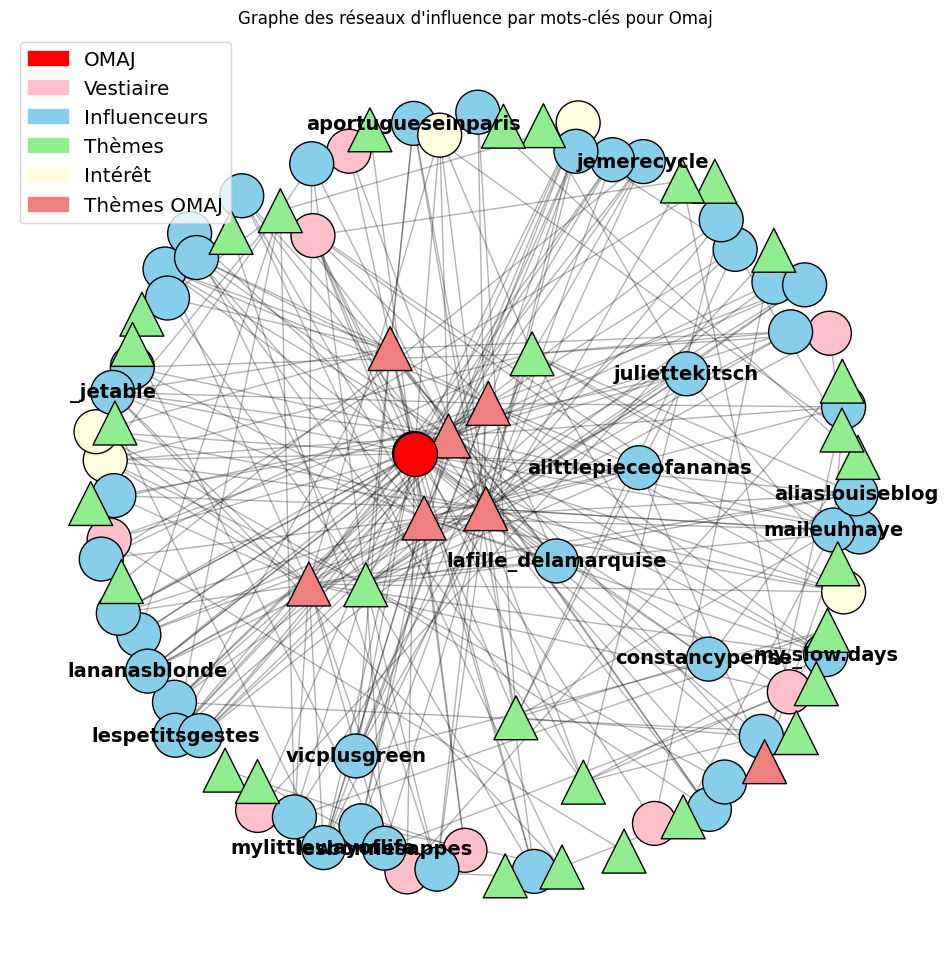

In [56]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

df = pd.read_csv('../data/data.csv', sep=';')

keywords = set()
for content in df["TYPE DE CONTENU"]:
    cleaned_keywords = [keyword.strip() for keyword in content.split(",")]
    keywords.update(cleaned_keywords)

for keyword in keywords:
    df[keyword] = df["TYPE DE CONTENU"].apply(lambda x: 1 if keyword in [k.strip() for k in x.split(",")] else 0)


highlight_influencers = [
    'claire_arnoux', 'iznowgood_', 'chloeandyou', 'mathildeclauzet', 
    'bonjourlasmala', 'melting.green', 'lapetillante_ju', 
    'asundaymorningperrine', 'carine.galli'
]
highlight_keywords =[
    'économie responsable', 'secondemain','mode éthique', 'durable', 'engagée', 'économie circulaire', 'slow'
]

G = nx.Graph()

for influencer in df['INFLUENCEURS']:
    G.add_node(influencer, type='influencer')


keywords = df.columns[4:]
for keyword in keywords:
    G.add_node(keyword, type='keyword')


for index, row in df.iterrows():
    influencer = row['INFLUENCEURS']
    for keyword in keywords:
        if row[keyword] == 1:
            G.add_edge(influencer, keyword)
    

    if row['SUIT OMAJ'] == 1 and row['SUIVI PAR OMAJ'] == 0:
        G.add_edge(influencer, "OMAJ")
    elif row['SUIT OMAJ'] == 1 and row['SUIVI PAR OMAJ'] == 1:
        G.add_edge(influencer, "OMAJ")
        G.add_edge("OMAJ", influencer)
    elif row['SUIT OMAJ'] == 0 and row['SUIVI PAR OMAJ'] == 1:
        G.add_edge("OMAJ", influencer)

influencers = [n for n, attr in G.nodes(data=True) if attr['type'] == 'influencer']
keywords = [n for n, attr in G.nodes(data=True) if attr['type'] == 'keyword']


node_colors = []
for node in G.nodes():
    if node == "OMAJ":
        node_colors.append("red")
    elif node in highlight_influencers:
        node_colors.append('pink')
    elif node in highlight_keywords:
        node_colors.append('lightcoral')
    elif node in influencers:
        suit_omaj = df[df['INFLUENCEURS'] == node]['SUIT OMAJ'].values[0]
        suivi_par_omaj = df[df['INFLUENCEURS'] == node]['SUIVI PAR OMAJ'].values[0]
        if suit_omaj == 1 and suivi_par_omaj == 0:
            node_colors.append("lightyellow")
        else:
            node_colors.append("skyblue")
    else:
        node_colors.append("lightgreen")


centrality = nx.degree_centrality(G)


num_top_nodes = 15  
central_blue_nodes = sorted([node for node in influencers if node_colors[list(G.nodes()).index(node)] == "skyblue"], key=lambda x: centrality[x], reverse=True)[:num_top_nodes]

plt.figure(figsize=(12, 12))


pos = nx.spring_layout(G, k=3, iterations=102, seed=123)


nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=[node_colors[i] for i, n in enumerate(G.nodes()) if n in influencers], edgecolors='black', nodelist=influencers)
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=[node_colors[i] for i, n in enumerate(G.nodes()) if n in keywords], edgecolors='black', nodelist=keywords, node_shape='^')
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='red', edgecolors='black', nodelist=['OMAJ'])
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.3)


labels = {n: n for n in central_blue_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=14, font_weight='bold')


red_patch = mpatches.Patch(color='red', label='OMAJ')
pink_patch = mpatches.Patch(color='pink', label='Vestiaire')
blue_patch = mpatches.Patch(color='skyblue', label='Influenceurs')
green_patch = mpatches.Patch(color='lightgreen', label='Thèmes')
yellow_patch = mpatches.Patch(color='lightyellow', label='Intérêt')
lightcoral_patch = mpatches.Patch(color='lightcoral', label='Thèmes OMAJ')
plt.legend(handles=[red_patch, pink_patch, blue_patch, green_patch, yellow_patch, lightcoral_patch], loc='upper left', fontsize='x-large')

plt.title("Graphe des réseaux d'influence par mots-clés pour Omaj")
plt.axis('off')
plt.show()


In [45]:
#df.to_csv('matrice_finale.csv')

# Réseaux de communautés

Number of communities detected: 9


C:\Users\hosfa\AppData\Local\Temp\ipykernel_19152\424538489.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', num_communities)


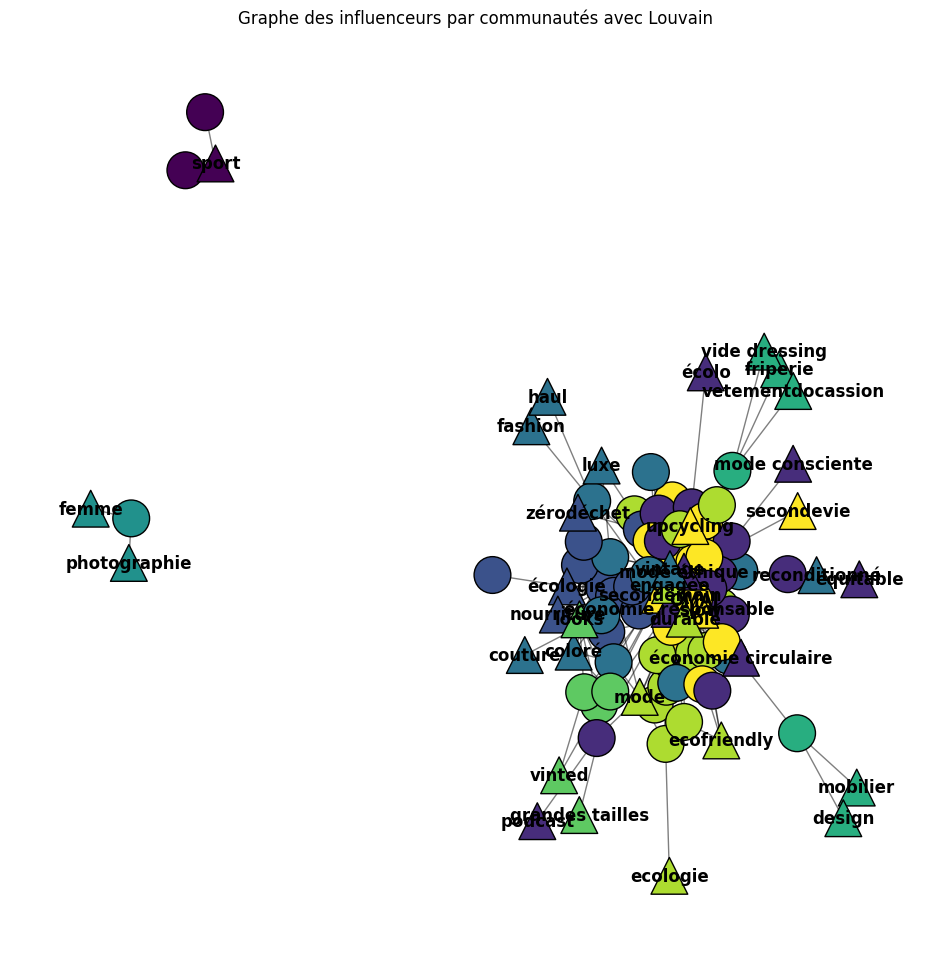

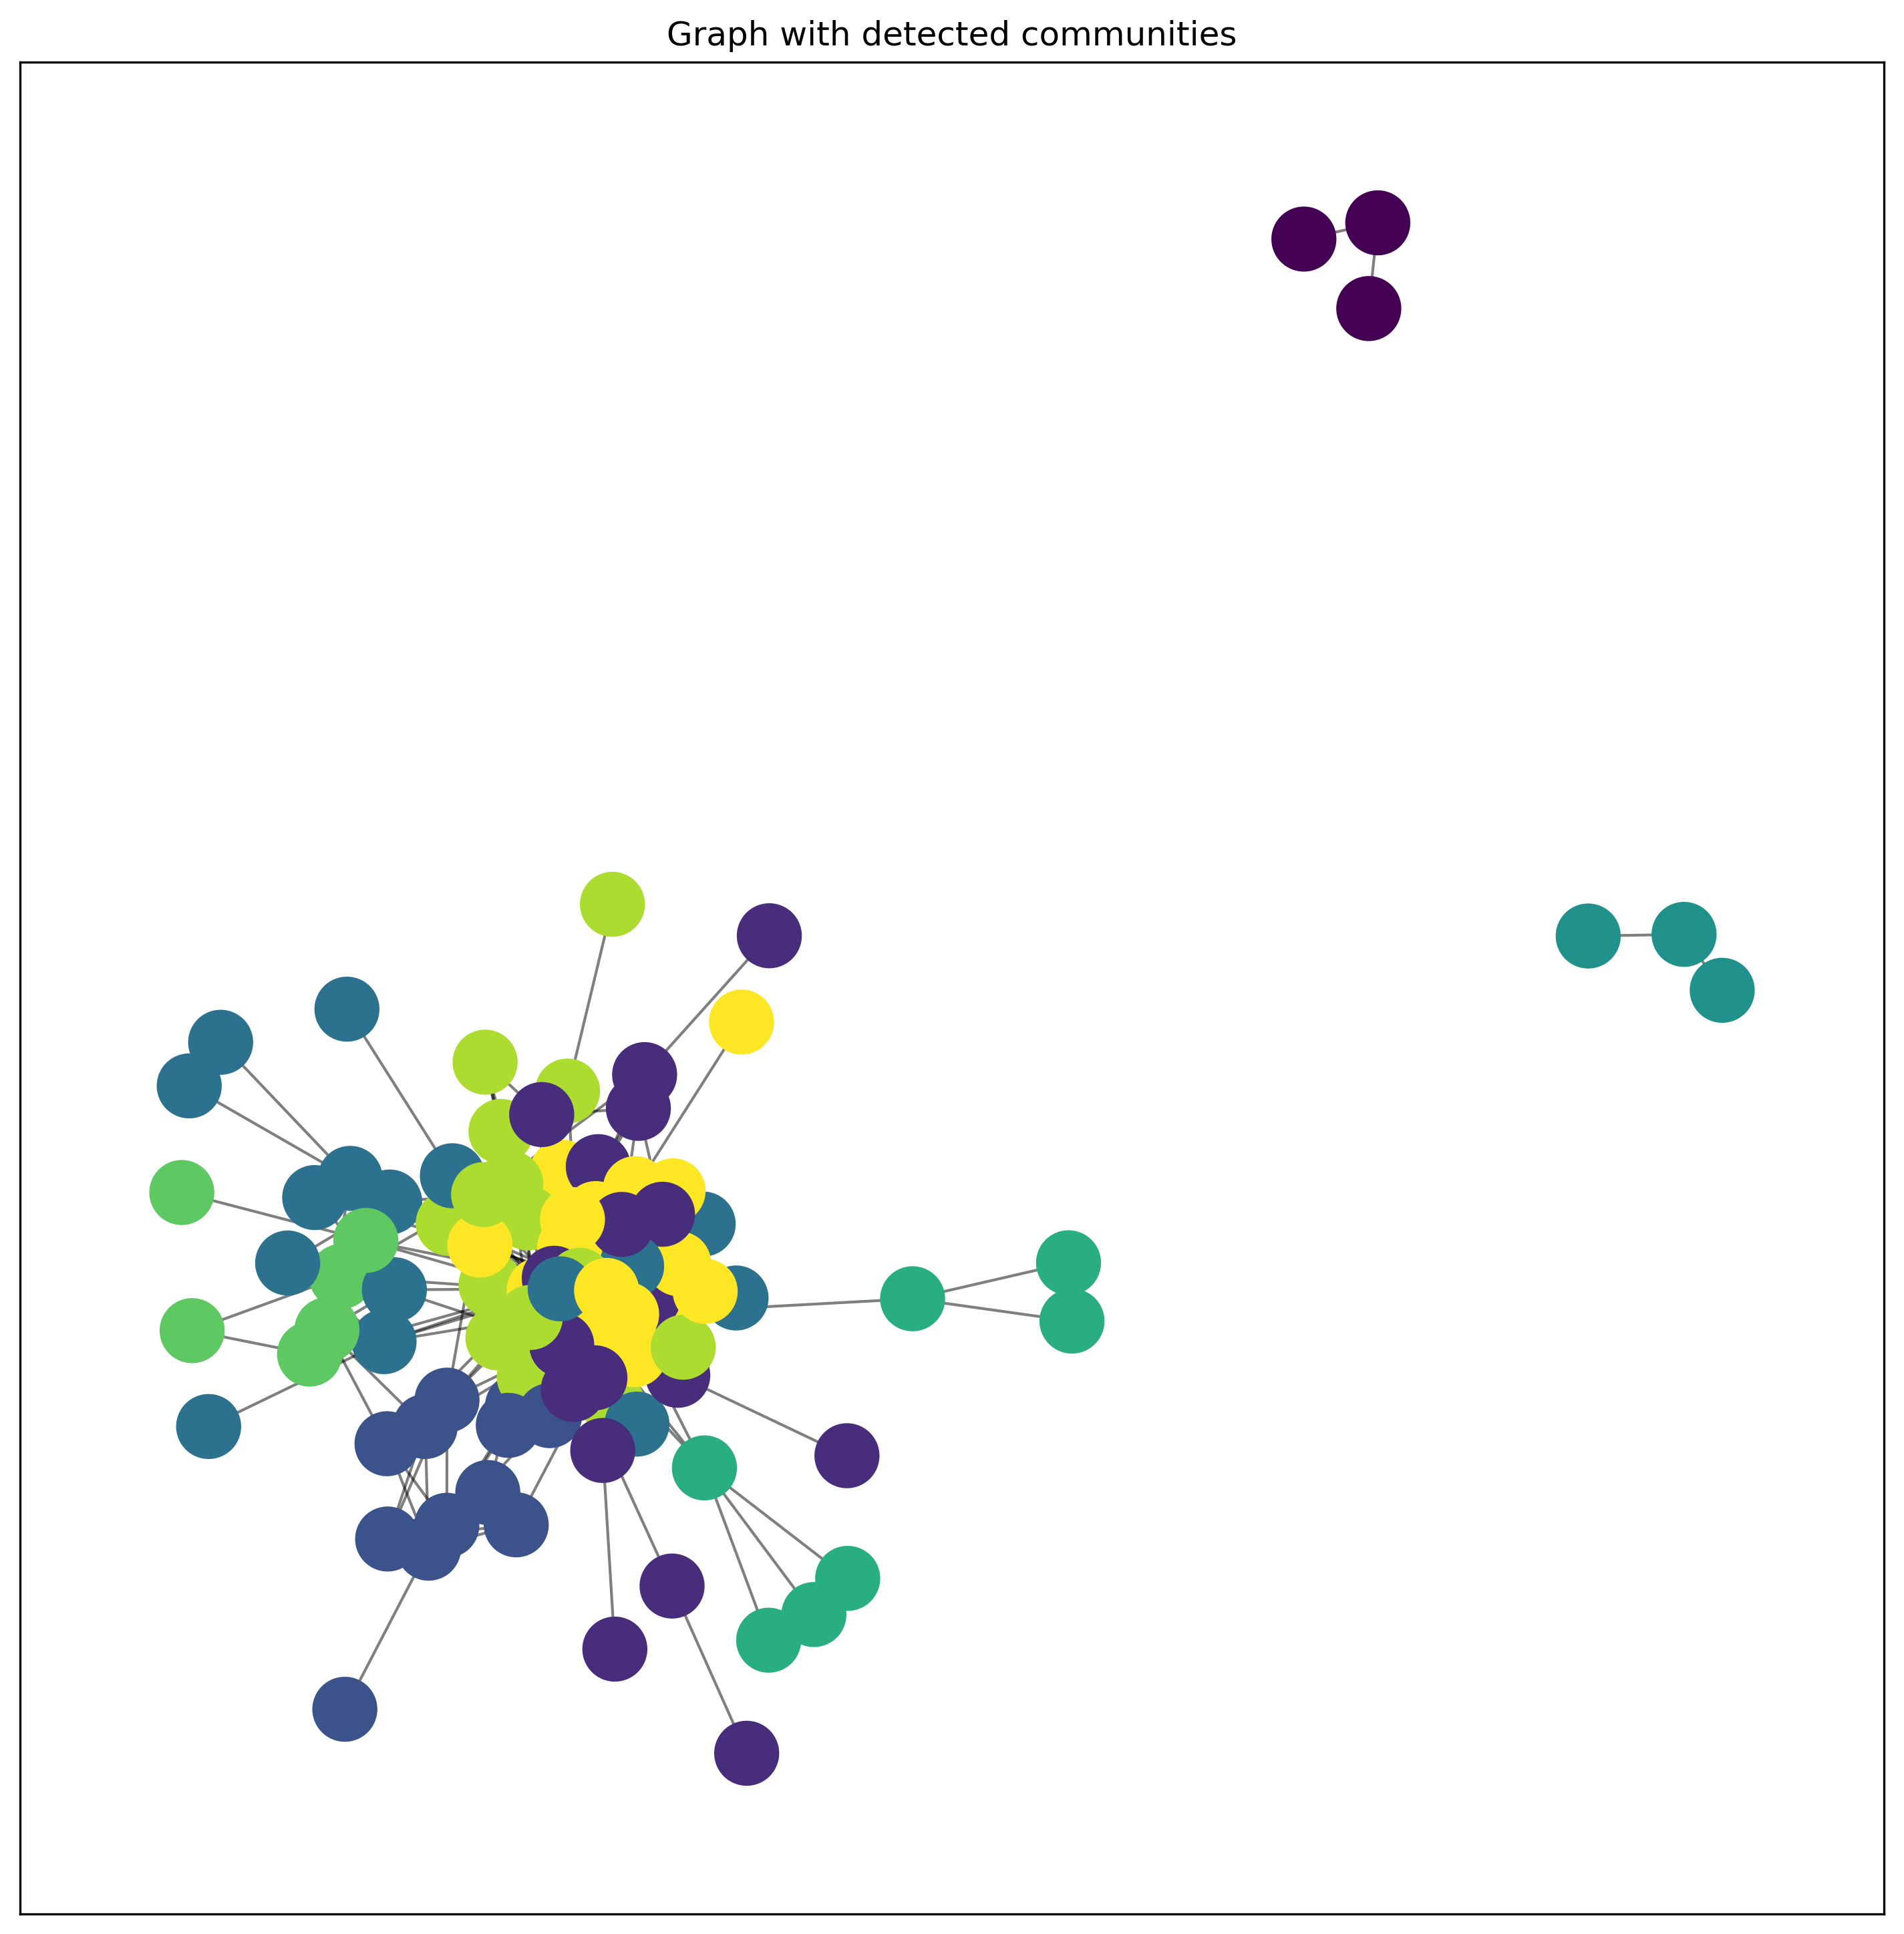

In [55]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from communities.algorithms import louvain_method
from communities.visualization import draw_communities


df = pd.read_csv('../data/data.csv', sep=';')


keywords = set()
for content in df["TYPE DE CONTENU"]:
    cleaned_keywords = [keyword.strip() for keyword in content.split(",")]
    keywords.update(cleaned_keywords)

for keyword in keywords:
    df[keyword] = df["TYPE DE CONTENU"].apply(lambda x: 1 if keyword in [k.strip() for k in x.split(",")] else 0)


G = nx.Graph()

for influencer in df['INFLUENCEURS']:
    G.add_node(influencer, type='influencer')

G.add_node("OMAJ", type='omaj')

keyword_columns = df.columns[4:]
for keyword in keyword_columns:
    if keyword != "TYPE DE CONTENU":
        G.add_node(keyword, type='keyword')

for index, row in df.iterrows():
    influencer = row['INFLUENCEURS']
    for keyword in keyword_columns:
        if keyword != "TYPE DE CONTENU" and row[keyword] == 1:
            G.add_edge(influencer, keyword)
    
    if row['SUIT OMAJ'] == 1 and row['SUIVI PAR OMAJ'] == 0:
        G.add_edge(influencer, "OMAJ")


adj_matrix = nx.to_numpy_array(G)

communities, frames = louvain_method(adj_matrix)

index_to_node = {i: node for i, node in enumerate(G.nodes())}


node_community_map = {}
for community_index, community in enumerate(communities):
    for node in community:
        node_name = index_to_node[node]
        node_community_map[node_name] = community_index


num_communities = len(set(node_community_map.values()))
print(f"Number of communities detected: {num_communities}")


colors = cm.get_cmap('viridis', num_communities)
color_map = [colors(node_community_map[node] / num_communities) for node in G.nodes()]


pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))


influencers = [node for node, data in G.nodes(data=True) if data['type'] == 'influencer' or node == 'OMAJ']
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=[color_map[list(G.nodes()).index(node)] for node in influencers], edgecolors='black', nodelist=influencers)


keyword_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'keyword']
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=[color_map[list(G.nodes()).index(node)] for node in keyword_nodes], edgecolors='black', nodelist=keyword_nodes, node_shape='^')
nx.draw_networkx_edges(G, pos, alpha=0.5)


labels = {n: n for n in G.nodes() if n == "OMAJ" or n in keywords}
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_weight='bold')


plt.title("Graphe des influenceurs par communautés avec Louvain")
plt.axis('off')
plt.show()


def fixed_draw_communities(adj_matrix, communities, dark=False, filename=None, dpi=300, seed=None):
    np.random.seed(seed)

    G = nx.from_numpy_array(adj_matrix) 
    partition = [0 for _ in range(G.number_of_nodes())]
    for c_i, nodes in enumerate(communities):
        for node in nodes:
            partition[node] = c_i

    plt.figure(figsize=(12, 12), dpi=dpi)
    pos = nx.spring_layout(G, seed=seed)
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    node_color = [partition[n] for n in G.nodes()]
    cmap = plt.get_cmap('viridis', max(node_color) + 1)
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_color, cmap=cmap)
    plt.title("Graph with detected communities")
    plt.show()


fixed_draw_communities(adj_matrix, communities)


In [14]:

degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)


influencer_nodes = [node for node in G.nodes if G.nodes[node]['type'] == 'influencer']


centrality_df = pd.DataFrame({
    'Influencer': influencer_nodes,
    'Degree Centrality': [degree_centrality[node] for node in influencer_nodes],
    'Betweenness Centrality': [betweenness_centrality[node] for node in influencer_nodes],
    'Closeness Centrality': [closeness_centrality[node] for node in influencer_nodes],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in influencer_nodes]
})


centrality_df.sort_values(by='Closeness Centrality', ascending=False, inplace=True)


print(centrality_df.head())

           Influencer  Degree Centrality  Betweenness Centrality  \
34         alyssuuurr           0.072917                0.013290   
45  emmaverdierkremer           0.072917                0.017696   
54   jesuisunebelette           0.062500                0.008843   
28             zoekrk           0.052083                0.006312   
43  mylittlewayoflife           0.062500                0.028092   

    Closeness Centrality  Eigenvector Centrality  
34              0.417698                0.150208  
45              0.409587                0.146455  
54              0.407609                0.145224  
28              0.405649                0.116620  
43              0.405649                0.140155  
